In [ ]:
### the base version from o1

In [86]:
# Bayesian Estimation of Mixture Ratios in Mitochondrial DNA Samples

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.interpolate import interp1d

In [98]:
# **1. Simulation of Mitochondrial Genomes for Samples R and D**

# Parameters
L = 16569          # Length of mitochondrial genome (human mtDNA)
M = 50            # Number of informative positions
mean_depth = 800   # Mean sequencing depth
epsilon = 0.05     # Sequencing error rate
alleles = ['A', 'C', 'G', 'T']
np.random.seed(42) # For reproducibility

# Generate informative positions (positions where D differs from R)
positions = np.arange(1, M+1)

# Assign alleles to sample R
alleles_R = np.random.choice(alleles, M)

# Assign different alleles to sample D at the same positions
alleles_D = []
for allele_R in alleles_R:
    other_alleles = [a for a in alleles if a != allele_R]
    allele_D = np.random.choice(other_alleles)
    alleles_D.append(allele_D)
alleles_D = np.array(alleles_D)

In [99]:
# **2. Function to Simulate Sequencing Reads for Mixed Sample RDM**

def simulate_reads(p_true, M, mean_depth, epsilon):
    """
    Simulate sequencing reads for the mixed sample RDM.
    """
    # Simulate total reads at each position
    n_reads = np.random.poisson(lam=mean_depth, size=M)
    
    # Expected frequency of D-specific allele at each position
    f_i = p_true * (1 - epsilon) + (1 - p_true) * epsilon
    
    # Simulate number of reads supporting D-specific allele at each position
    k_reads = np.random.binomial(n_reads, f_i)
    
    return k_reads, n_reads


In [100]:
# **3. Function to Compute Log Likelihood**

def log_likelihood(p, k_reads, n_reads, epsilon):
    """
    Compute the log likelihood of observing the data given mixture proportion p.
    """
    f_i = p * (1 - epsilon) + (1 - p) * epsilon
    f_i = np.clip(f_i, 1e-10, 1 - 1e-10)  # Avoid log(0)
    log_L_i = binom.logpmf(k_reads, n_reads, f_i)
    log_L = np.sum(log_L_i)
    return log_L

In [101]:
# **4. Function to Perform Bayesian Inference**

def bayesian_estimation(k_reads, n_reads, epsilon):
    """
    Perform Bayesian estimation of the mixture proportion p.
    """
    # Define a grid of p values
    p_grid = np.linspace(0, 0.05, 2000)
    
    # Compute log likelihood for each p
    log_L_values = np.array([log_likelihood(p, k_reads, n_reads, epsilon) for p in p_grid])
    
    # Convert log likelihoods to likelihoods
    L_values = np.exp(log_L_values - np.max(log_L_values))  # For numerical stability
    
    # Assume a uniform prior over p (from 0% to 5%)
    posterior = L_values / np.sum(L_values)
    
    # Compute estimates
    p_est_mean = np.sum(p_grid * posterior)
    cumulative_posterior = np.cumsum(posterior)
    interp_cdf = interp1d(cumulative_posterior, p_grid)
    p_est_median = interp_cdf(0.5)
    p_est_mode = p_grid[np.argmax(posterior)]
    lower_bound = interp_cdf(0.025)
    upper_bound = interp_cdf(0.975)
    
    return {
        'p_grid': p_grid,
        'posterior': posterior,
        'p_est_mean': p_est_mean,
        'p_est_median': p_est_median,
        'p_est_mode': p_est_mode,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }


In [102]:
# **5. Simulation and Estimation Function**

def simulate_and_estimate(p_true, M, mean_depth, epsilon):
    """
    Simulate data and estimate the mixture proportion p.
    """
    # Simulate sequencing reads
    k_reads, n_reads = simulate_reads(p_true, M, mean_depth, epsilon)
    
    # Perform Bayesian estimation
    estimation_results = bayesian_estimation(k_reads, n_reads, epsilon)
    
    # Include true p in results
    estimation_results['p_true'] = p_true
    return estimation_results

In [103]:
# **6. Validation with Simulated Data**

# Test mixture proportions
p_true_values = [0.001, 0.005, 0.01, 0.02]

# Collect results
results_list = []

for p_true in p_true_values:
    results = simulate_and_estimate(p_true, M, mean_depth, epsilon)
    results_list.append(results)
    print(f"True p: {p_true*100:.2f}%")
    print(f"Estimated p (mean): {results['p_est_mean']*100:.4f}%")
    print(f"Estimated p (median): {results['p_est_median']*100:.4f}%")
    print(f"Estimated p (mode): {results['p_est_mode']*100:.4f}%")
    print(f"95% Credible Interval: [{results['lower_bound']*100:.4f}%, {results['upper_bound']*100:.4f}%]")
    print("-" * 50)


True p: 0.10%
Estimated p (mean): 0.2410%
Estimated p (median): 0.2353%
Estimated p (mode): 0.2301%
95% Credible Interval: [0.0326%, 0.4772%]
--------------------------------------------------
True p: 0.50%
Estimated p (mean): 0.4837%
Estimated p (median): 0.4816%
Estimated p (mode): 0.4802%
95% Credible Interval: [0.2374%, 0.7322%]
--------------------------------------------------
True p: 1.00%
Estimated p (mean): 0.7941%
Estimated p (median): 0.7920%
Estimated p (mode): 0.7904%
95% Credible Interval: [0.5405%, 1.0499%]
--------------------------------------------------
True p: 2.00%
Estimated p (mean): 2.0089%
Estimated p (median): 2.0068%
Estimated p (mode): 2.0060%
95% Credible Interval: [1.7350%, 2.2848%]
--------------------------------------------------


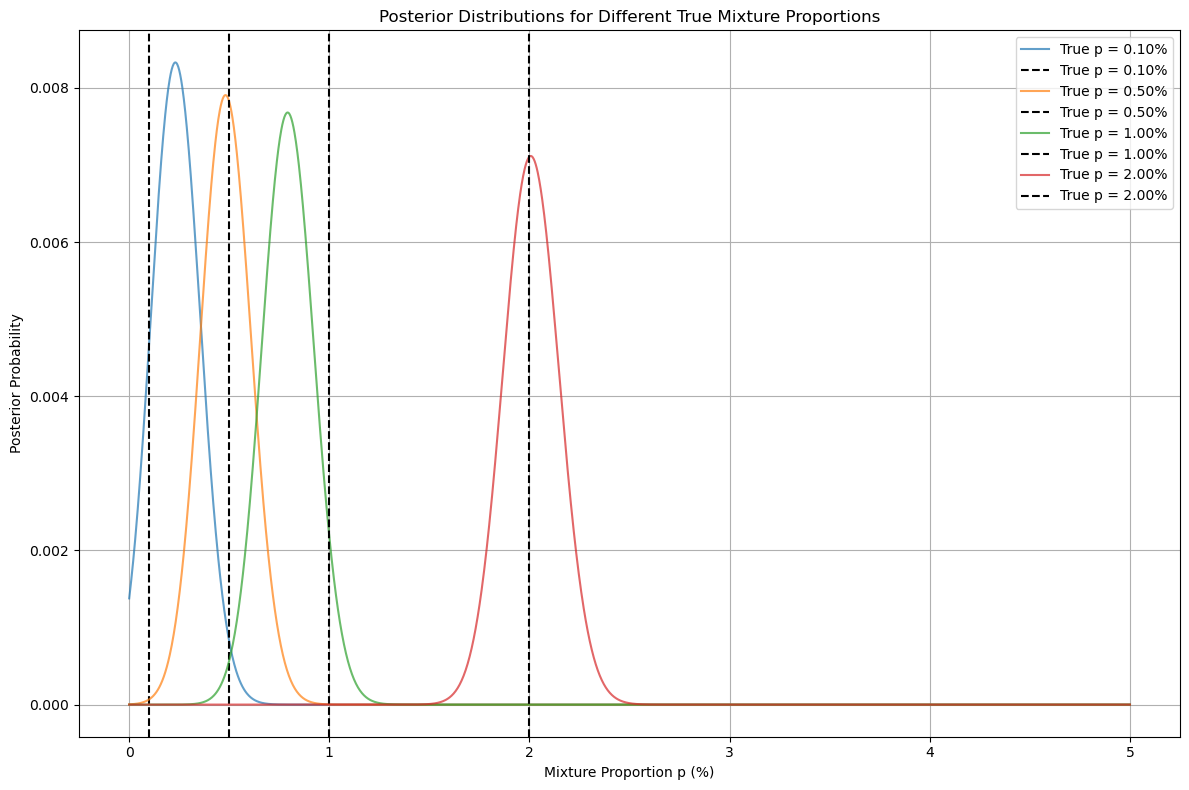

In [104]:

def plot_posterior_distribution(results_list):
    """
    Plot the posterior distributions of p for different true mixture proportions,
    with a dashed line indicating the true p-value on the x-axis.
    
    Args:
    results_list (list): A list of result dictionaries from simulate_and_estimate(),
                         where each dictionary contains the posterior distribution
                         and the true p-value ('p_true').
    """
    plt.figure(figsize=(12, 8))

    for results in results_list:
        # Plot the posterior distribution
        plt.plot(results['p_grid']*100, results['posterior'], label=f"True p = {results['p_true']*100:.2f}%", alpha=0.7)

        # Add a dashed line for the true p value on the x-axis
        plt.axvline(results['p_true']*100, color='black', linestyle='--', label=f'True p = {results["p_true"]*100:.2f}%')
    
    plt.xlabel('Mixture Proportion p (%)')
    plt.ylabel('Posterior Probability')
    plt.title('Posterior Distributions for Different True Mixture Proportions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Assuming `results_list` is a list of results from the simulate_and_estimate function
plot_posterior_distribution(results_list)


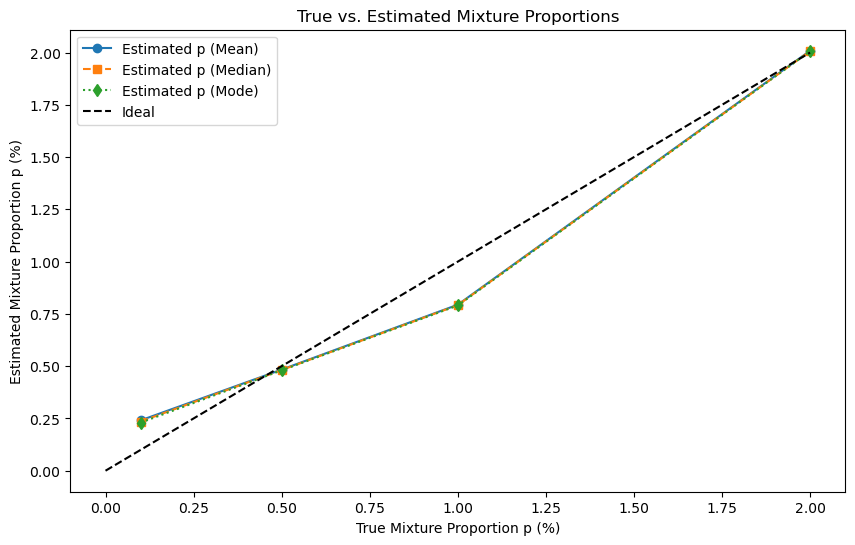

In [106]:
# **8. Performance Evaluation**

# Extract true and estimated p values
true_p_values = [res['p_true'] for res in results_list]
estimated_p_means = [res['p_est_mean'] for res in results_list]
estimated_p_medians = [res['p_est_median'] for res in results_list]
estimated_p_modes = [res['p_est_mode'] for res in results_list]

# Plot True vs. Estimated p
plt.figure(figsize=(10, 6))
plt.plot(np.array(true_p_values)*100, np.array(estimated_p_means)*100, 'o-', label='Estimated p (Mean)')
plt.plot(np.array(true_p_values)*100, np.array(estimated_p_medians)*100, 's--', label='Estimated p (Median)')
plt.plot(np.array(true_p_values)*100, np.array(estimated_p_modes)*100, 'd:', label='Estimated p (Mode)')
plt.plot([0, 2], [0, 2], 'k--', label='Ideal')
plt.xlabel('True Mixture Proportion p (%)')
plt.ylabel('Estimated Mixture Proportion p (%)')
plt.title('True vs. Estimated Mixture Proportions')
plt.legend()
plt.show()

In [107]:
# **9. Sensitivity Analysis**

# Vary sequencing depth
depth_values = [50, 100, 200, 500]
p_true = 0.01  # Fixed true p at 0.5%
results_depth = []

for depth in depth_values:
    results = simulate_and_estimate(p_true, M, depth, epsilon)
    results_depth.append(results)
    print(f"Sequencing Depth: {depth}x")
    print(f"Estimated p (mean): {results['p_est_mean']*100:.4f}%")
    print(f"95% Credible Interval: [{results['lower_bound']*100:.4f}%, {results['upper_bound']*100:.4f}%]")
    print("-" * 50)


Sequencing Depth: 50x
Estimated p (mean): 1.6418%
95% Credible Interval: [0.6218%, 2.7334%]
--------------------------------------------------
Sequencing Depth: 100x
Estimated p (mean): 0.9707%
95% Credible Interval: [0.2717%, 1.7172%]
--------------------------------------------------
Sequencing Depth: 200x
Estimated p (mean): 0.9023%
95% Credible Interval: [0.4022%, 1.4189%]
--------------------------------------------------
Sequencing Depth: 500x
Estimated p (mean): 0.9573%
95% Credible Interval: [0.6339%, 1.2857%]
--------------------------------------------------


In [108]:
import matplotlib.pyplot as plt

def inspect_simulated_data(k_reads, n_reads, epsilon):
    """
    Inspect and visualize the simulated data including the distribution of read counts and errors 
    against the informative positions.
    
    Args:
    k_reads (array): Number of reads supporting D-specific allele at each position.
    n_reads (array): Total number of reads at each position.
    epsilon (float): Sequencing error rate.
    """
    positions = np.arange(1, len(k_reads) + 1)

    # Plotting read counts (k_reads and n_reads) against positions
    plt.figure(figsize=(10, 6))

    # Plot k_reads and n_reads on the same graph for comparison
    plt.plot(positions, k_reads, label='k_reads (D-specific reads)', marker='o', color='blue', alpha=0.7)
    plt.plot(positions, n_reads, label='n_reads (Total reads)', marker='x', color='red', alpha=0.7)
    plt.xlabel('Position (Informative Position)')
    plt.ylabel('Read Counts')
    plt.title('Read Counts at Each Informative Position')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting error distribution (observed - expected frequencies) against positions
    observed_frequencies = k_reads / n_reads
    expected_frequencies = epsilon + (1 - epsilon) * observed_frequencies
    error_distribution = observed_frequencies - expected_frequencies
    
    plt.figure(figsize=(8, 5))
    plt.plot(positions, error_distribution, label='Error (Observed - Expected)', marker='o', color='green', alpha=0.7)
    plt.xlabel('Position (Informative Position)')
    plt.ylabel('Error (Observed - Expected Frequency)')
    plt.title('Error Distribution Across Informative Positions')
    plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
    plt.grid(True)
    plt.tight_layout()
    plt.show()



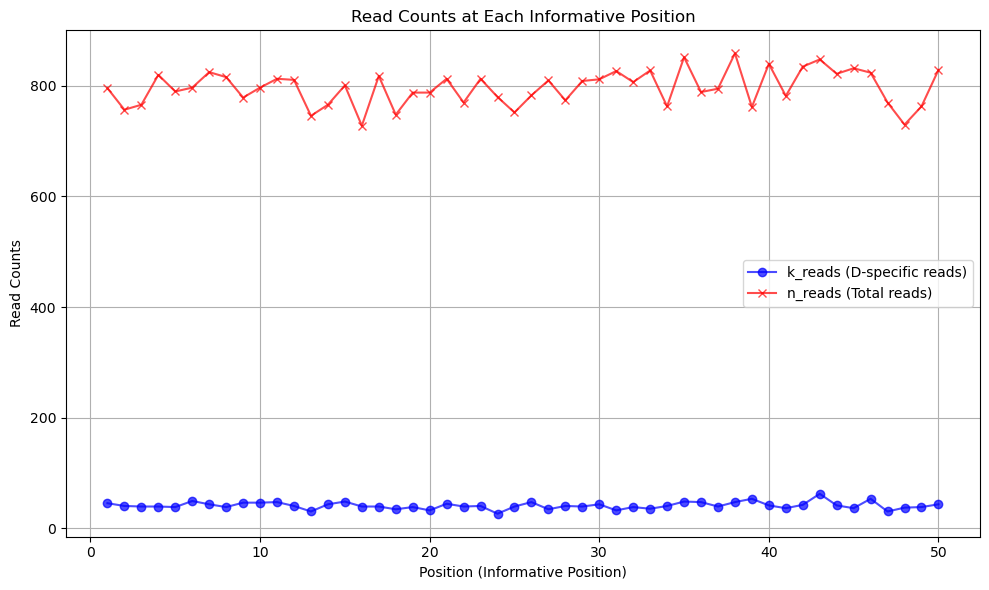

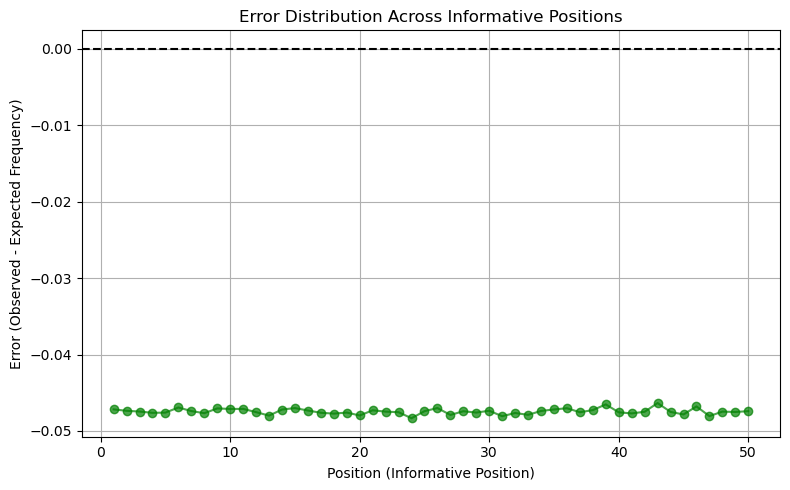

In [109]:
# Example usage:
p_true = 0.001  # True mixture proportion
k_reads, n_reads = simulate_reads(p_true, M, mean_depth, epsilon)
inspect_simulated_data(k_reads, n_reads, epsilon)


In [20]:
# **10. Conclusion**

# The Bayesian method accurately estimates mixture proportions as low as 0.1% with sufficient read depth and number of informative positions. The method is robust to sequencing errors due to incorporation of the error rate in the model.
